In [33]:
library(tidyverse)
library(dbplyr)
library(DBI)
library(purrr)
library(tidymodels)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [35]:
url <- "https://raw.githubusercontent.com/Ivvvyyan/dsci-group-11/main/StressLevelDataset.csv"

#change 0, 1, 2 to "Tension Free" "Under Pressure" "Stressful"
# load the unscaled cancer data 
# and make sure the response variable, stress_level, is a factor
stress_data <- read_csv(url)
unscaled_stress <- stress_data |>
# convert the character stress_level variable to the factor datatype
                        mutate(stress_level = as_factor(stress_level))|>
  # rename the factor values to be more readable
                        mutate(stress_level = fct_recode(stress_level, "Tension Free" = "0", "Under Pressure" = "1", "Stressful" = "2"))

# create the KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

# create the centering / scaling recipe
us_recipe <- recipe(stress_level ~ academic_performance + social_support, data = unscaled_stress) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(us_recipe) |>
  add_model(knn_spec) |>
  fit(data = unscaled_stress)

knn_fit

Rows: 1100 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): anxiety_level, self_esteem, mental_health_history, depression, hea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1009091
Best kernel: rectangular
Best k: 7

In [36]:
new_observation <- tibble(academic_performance = c(1, 4), social_support = c(2, 2))
prediction <- predict(knn_fit, new_observation)

prediction

.pred_class   
1 Under Pressure
2 Under Pressure

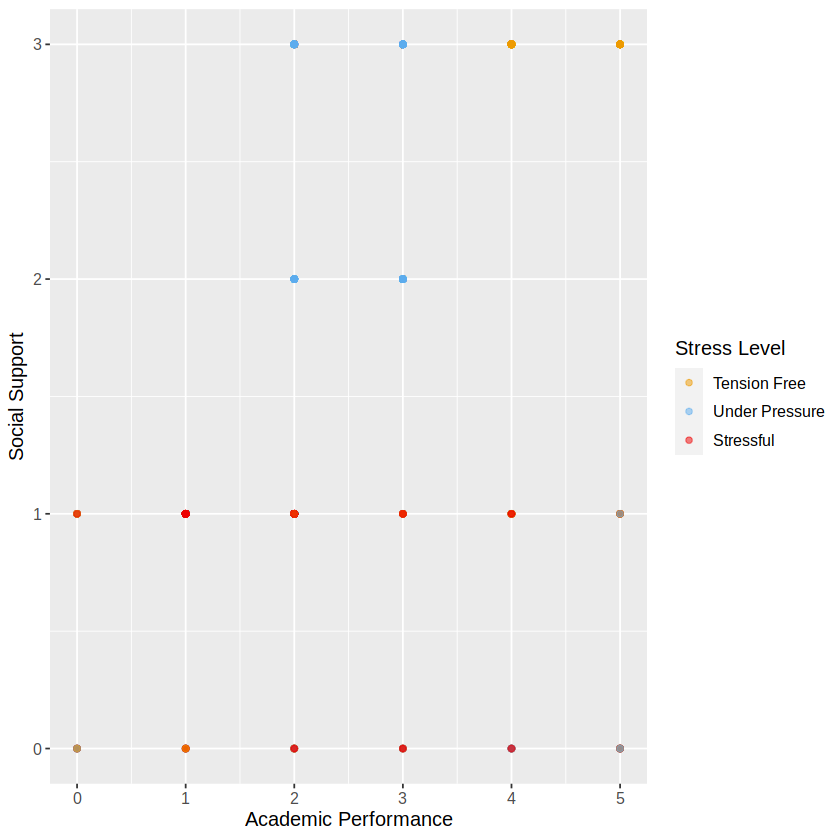

In [40]:
# create scatter plot of Academic performance vs Social Support,
# labeling the points be Stress Level
acade_social <- unscaled_stress |>
  ggplot(aes(x = academic_performance, y = social_support, color = stress_level)) +
  geom_point(alpha = 0.5) +
  labs(x = "Academic Performance", y = "Social Support", color = "Stress Level") +
  scale_color_manual(values = c("orange2", "steelblue2", "red2")) + 
  theme(text = element_text(size = 12))

acade_social

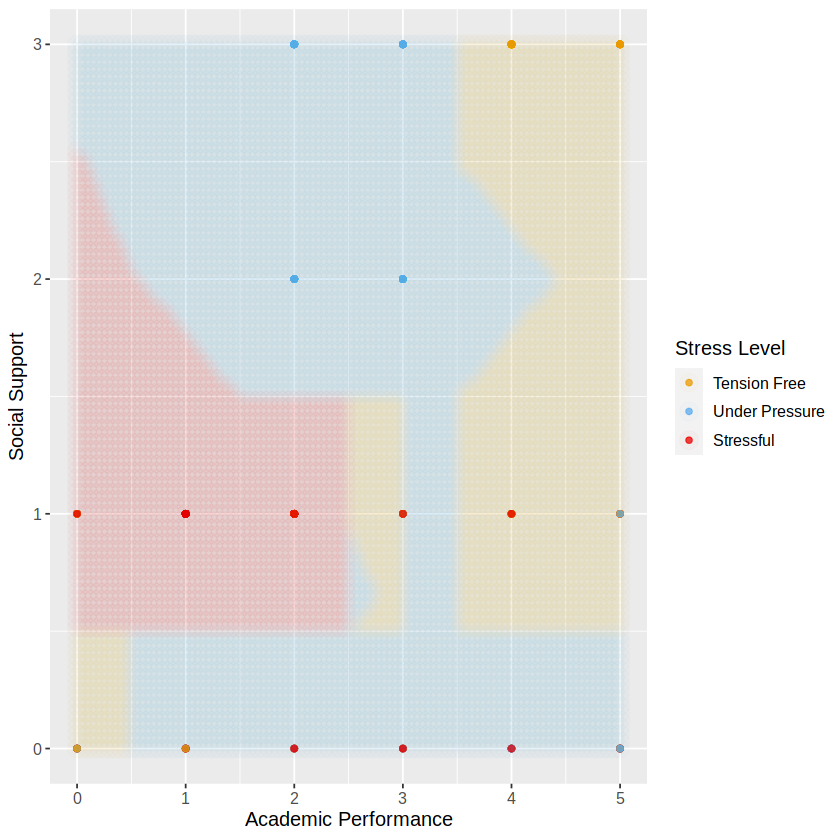

In [37]:
# create the grid of academic/social vals, and arrange in a data frame
academic_grid <- seq(min(unscaled_stress$academic_performance), 
                max(unscaled_stress$academic_performance), 
                length.out = 100)
social_grid <- seq(min(unscaled_stress$social_support), 
                max(unscaled_stress$social_support), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(academic_performance = academic_grid, 
                                social_support = social_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(stress_level = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = unscaled_stress, 
             mapping = aes(x = academic_performance, 
                           y = social_support, 
                           color = stress_level), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = academic_performance, 
                           y = social_support, 
                           color = stress_level), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Stress Level", 
       x = "Academic Performance", 
       y = "Social Support") +
  scale_color_manual(values = c("orange2", "steelblue2", "red2")) +
  theme(text = element_text(size = 12))

wkflw_plot